# Impedance control

The goal of today's laboratory is to implement an impedance controller to directly control the end-effector of the robot.

## Instructions
Answer all the questions below and submit a pdf with detailed answers to these questions, including the plots through Brightspace. You will also need to submit the Jupyter notebooks with the code used to answer the questions.

## Robot model
<img src="./3d_robot_model.png" width="500">

In [1]:
# we import useful libraries
from time import sleep, time as t
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
# this function returns the body Jacobian
from robot_utils import getBodyJacobianOrientedLikeSpatialFrame

# we import the robot class
use_real_robot = False

if use_real_robot:
    from NYUFinger.real import NYUFingerHardware    
else:
    from NYUFinger.sim import NYUFingerSimulator
    
    
# here we define the global variables for the robot size
l0 = 0.3
l1 = 0.16
l2 = 0.16
l3 = 0.014

# Impedance control

As seen in class, an impedance controller in the end-effector space allows to directly control the motion of the end-effector using the relationship $\tau = J^T F_{finger}$, where $\tau$ is the vector of motor torques and $F_{finger}$ the 3D force at the end-effector.
For a desired force $F_{pos}$, we can directly compute the required motor torques $\tau$ without the need to compute
any inverse. We will use this relationship to move the finger.

## A note on the Jacobian
* In the laboratory we will ignore the orientation of the end-effector, so we will only consider the bottom three rows of the Jacobian (i.e. the rows associated to the linear velocity).
* The function ``getBodyJacobianOrientedLikeSpatialFrame`` returns this Jacobian (you need to pass an array of joint angles as input). Only the bottom three rows of the Jacobian are returned, i.e. the rows corresponding to the linear velocity.
* The function returns the Jacobian of the end-effector such that $J \dot{\theta}$ gives the linear velocity of the end-effector (the point F) in the S frame. This can also be thought as having the Jacobian in the frame O as shown in the figure above.


## The impedance controller

Assume we want the finger to behave as if springs and dampers were attached to it, as shown in this figure

<img src="./spring_schematics.png" width="200">

Consider the $x$ direction. An ideal spring will have a stiffness $K_x$ and a rest position $x_0$. Therefore, we should see a force pushing or pulling the finger according to $F_x = K_x (x_0 - x_{measured})$, where $x_{measured}$ is the measured position of the finger (make sure that $x_0$ and $x_{measured}$ are expressed in the same coordinate frame!)

In 3D, setting the rest position to $p_0 = [x_0, y_0, z_0]^T \in \mathbb{R}^3$, we will have a force $$F = K (p_0 - p_{measured})$$
where where $p_{measured}$ is the measured position of the finger in 3D and $K$ is a diagonal gain matrix that contains the stiffnesses of the 3 springs on its diagonal, i.e. 
$$K = \begin{bmatrix} K_x & 0 & 0 \\ 0 & K_y & 0 \\ 0 & 0 & K_z \end{bmatrix}$$

To implement this behavior, one can simply set the torques on the motors of the robot as

$ \tau = J^T K (p_0 - p_{measured})$ 

With this control law, the leg will then behave like a spring.

In addition to a spring, it is often a good idea to have a damper, that will dampen out any oscillations of the spring such that the leg can reach its rest position $p_0$ (otherwise it would oscillate forever). We can then also add a force conteracting velocity of the finger as
$-D \dot{p}_{measured}$, where $D$ is a diagonal matrix that contains the damping gains for each spring.

The resulting controller is then
$$\tau = J^T \Big( K (p_0 - p_{measured}) - D \dot{p}_{measured} \Big)$$

If one wants to track desired setpoint positions (e.g. a trajectory of setpoints) and maybe also a desired velocity,
we can easily adapt the impedance controller as follows
$$\tau = J^T \Big( K (p_{ref}(t) - p_{measured}) + D (\dot{p}_{ref}(t) - \dot{p}_{measured}) \Big)$$
where $p_{ref}(t)$ is a reference trajectory of set points. Note here how this resembles a PD controller in the end-effector space (it is in fact a PD controller).

## Questions
1. Write an impedance controller with a constant stiffness and $p_0 = [0.3, -0.2, 0.014]$. Tune the PD gains in all directions so that it stays in place as rigidly as possible.
 Plot the position of the end-effector and its velocity as a function of time starting from $q=[0, 0, 0]$. Does it behave as expected? Explain.

2. Write an impedance controller that can draw a circle in the x-y plane at a frequency of 0.5Hz, i.e. the end-effector should follow the trajectory $$x_{ref}(t) = \begin{pmatrix} 0.3 + 0.05\cos(\pi t) \\ -0.2 + 0.05 \sin(\pi t) \\ 0 \end{pmatrix}$$
Start with the gains you found in the previous section and further tune the conroller to get the best results. Plot the desired and measured positions of the finger as well as the desired and measured velocities of the finger.
3. Change the desired trajectory to draw the letter or symbol of your choice (attach a picture of what you draw in the report). Feel free to use any Python library, functionality to create this desired trajectory.
4. For part2 of this lab (week 2), attach a pen to the end-effector and try to draw on a paper using the robot. You will need to tune the PD gains along x and y directions for best tracking performance. You also need to change the PD gains and setpoints along the z direction so that the pen always pushes against the paper. What should you do for this behavior to occure? Explain and attach images of your drawings to the report.

**Note:** Feel free to create independent code cells for each step of the project to learn what you need to do before putting everything together in the next control loop. 

In [2]:
### COPY PASTE YOUR FORWARD KINEMATICS FUNCTION HERE FROM LAB 2 (and other helper functions)
def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[:3, 3] = vector
    
    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[1:3, 1:3] = [[cos, -sin], [sin, cos]]
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:3:2,0:3:2] = [[cos, sin], [-sin, cos]]
    
    ### we return the object
    return transform


def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:2,0:2] = [[cos, -sin], [sin, cos]]
    
    ### we return the object
    return transform


def forward_kinematics(theta):
    # assume theta is a vector, theta[0] = theta0, theta[1] = theta1, etc.
    # we define the lengths of the robot
    l0 = 0.3
    l1 = 0.16
    l2 = 0.16
    l3 = 0.014
    ###WRITE YOUR CODE HERE
    SH1=translate([l0, 0,0])@ rotateX(theta[0])
    H1H2= translate([0, 0, l3]) @ rotateZ(theta[1])
    H2K = translate([0, -l1, 0]) @ rotateZ(theta[2])
    KF = translate([0, -l2, 0])
    T_SH1=SH1
    T_SH2 = T_SH1 @ H1H2
    T_SK = T_SH2 @ H2K
    T_SF = T_SK @ KF
    ### we return the object
    return T_SF

In [3]:
import scipy.optimize


def fingertip_position_error(joint_angles, desired_fingertip_position):
    """
    fingertip_position_error function
    input joint_angles (as a 3D vector) and desired_fingertip_position (as a 3D vector)
    output the squared distance between the desired fingertip position and the one realized by joint_angles
    """
    p_fk = forward_kinematics(joint_angles)[0:3, 3]
    difference = p_fk-desired_fingertip_position
    
    return np.sum(np.power(difference, 2))


def inverse_geometry(desired_fingertip_position):
    """
    inverse geometry function
    input desired_fingertip_position (3D vector of desired position of the fingertip)
    output a vector of joint angles
    """
    # bound = [(0, 2*np.pi),(0, 2*np.pi),(0, 2*np.pi)]
    bound = [(-np.pi, np.pi),(-2*np.pi, 2*np.pi),(-2*np.pi, 2*np.pi)]
    result = scipy.optimize.minimize(fingertip_position_error, 
                                     np.array([0.01, 0.01, 0.01]), 
                                     args=(desired_fingertip_position), 
                                     bounds=bound
                                     )
    bounded_result = result.x
    # bounded_result[1:] = bounded_result[1:] % (2*np.pi)
    return bounded_result

In [4]:
def trajectory1(time):
    return [0.3, -0.2, 0.014], [0,0,0]

In [11]:
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerHardware()
    # Make sure the robot is in the zero configuration before running this cell
    robot.reset_sensors()
else:
    # we can now create a robot simulation
    robot = NYUFingerSimulator()
    robot.reset(np.zeros(3))
    
# we simulate for 10 seconds
run_time = 10.
dt = 0.01
num_steps = int(run_time/dt)

# Stiffness and damper
K = np.array([100, 100, 100])
D = np.array([2, 2, 2])

# Trajectory to use
trajectory = 1

## we allocate a few vectors to collect data while we do the simulation
# we will store the sensor values (angular position and velocities)
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
# we will store the commands sent to the robot
desired_torques = np.zeros_like(measured_positions)
# we will store the desired joint trajectories that the PD controller follows
desired_positions = np.zeros_like(measured_positions)
desired_velocities = np.zeros_like(measured_positions)
# we keep track of time
time = np.zeros([num_steps])
# we will store the end effector position (desired and measured)
measured_finger_position = np.zeros([num_steps,3])
desired_finger_position = np.zeros([num_steps,3])
measured_finger_velocity = np.zeros([num_steps,3])
desired_finger_velocity = np.zeros([num_steps,3])
# Start time
t_start = t()


for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = robot.get_state()
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    # save the current position of the finger using the FK function. Use your implementation from previous labs.
    pose = forward_kinematics(q)
    measured_finger_position[i,:] = pose[0:3,3]
    
    # controller: TODO HERE IMPLEMENT YOUR CONTROLLER
    jacobian = getBodyJacobianOrientedLikeSpatialFrame(q)
    if trajectory == 1:
        p_des, v_des = trajectory1(dt*i)
    v = jacobian.dot(dq)
    desired_finger_position[i,:] = p_des
    measured_finger_velocity[i, :] = v
    desired_finger_velocity[i, :] = v_des


    joint_torques = np.transpose(jacobian).dot(np.diag(K).dot(p_des-pose[0:3,3])+np.diag(D).dot(v_des - v))
    desired_torques[i,:] = joint_torques

    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    sleep(max(dt*(i+1) - (t()-t_start), 0))

print("Robot movement ends")

# for i in range(num_steps):
#     p_des, v_des = trajectory1(dt*i)
#     desired_positions[i,:] = inverse_geometry(p_des)
#     desired_velocities[i,:] = np.linalg.inv(jacobian).dot(v_des)

Robot movement ends


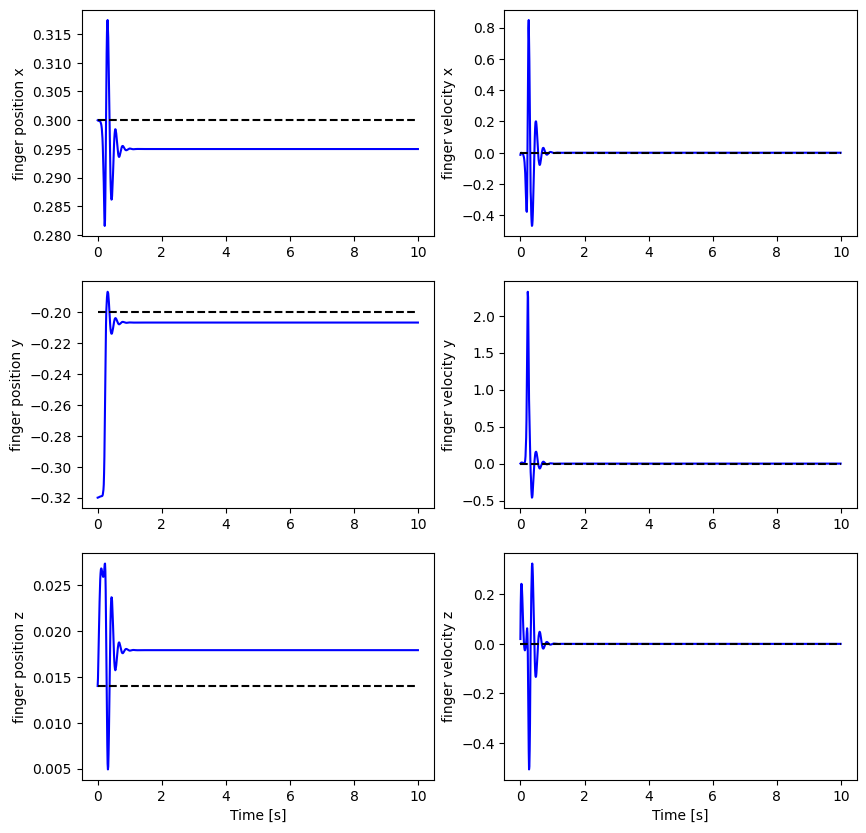

In [12]:
def plot_joint_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'finger position x')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'finger position y')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'finger position z')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'finger velocity x')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'finger velocity y')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'finger velocity z')
    plt.xlabel('Time [s]')
    
plot_joint_posvel(time, measured_finger_position, desired_finger_position, measured_finger_velocity, desired_finger_velocity)

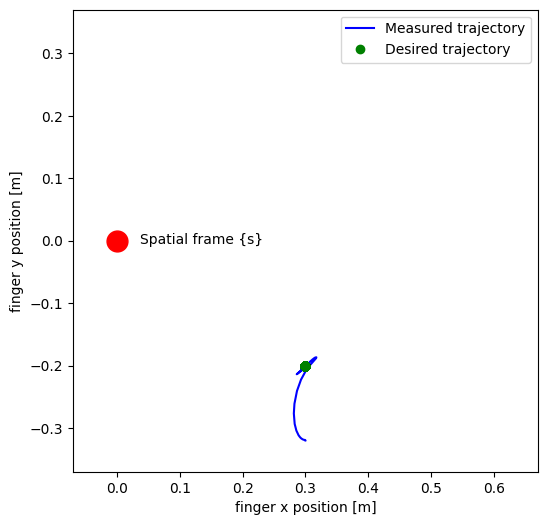

In [13]:
def plot_finger_trajectory(finger_position, desired_finger_position):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.plot(finger_position[:,0],finger_position[:,1], 'b')
    plt.plot(desired_finger_position[:,0],desired_finger_position[:,1], 'og')
    plt.xlabel('finger x position [m]')
    plt.ylabel('finger y position [m]')
    plt.legend(["Measured trajectory", "Desired trajectory"])
    plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
    plt.ylim([-l1-l2-0.05, l1+l2+0.05])
    plt.plot([0],[0],'o',markersize=15,color='r')
    
    ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    

plot_finger_trajectory(measured_finger_position, desired_finger_position)